## Importiere `pandas`, `matplotlib`

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import json
from datetime import datetime as dt
import locale
from scipy.interpolate import interp1d
from configparser import ConfigParser
from functions import *

## Lade die Konfigurationen aus `config.ini`
#### Definiere die Umgebung

In [79]:
config = ConfigParser()
files = config.read('config.ini')

# Wechsel des plt.style per config.ini machbar.
plt.style.use(config.get('theme', 'plt.style'))

# Damit Daten mit den deutschen Begriffen für die Monat generiert werden.
locale = locale.setlocale(locale.LC_TIME, "de_DE")

In [80]:
env = 'test'
database_file = config.get(env, 'database_file')
date_begin = config.get(env, 'date_begin')
date_end = config.get(env, 'date_end')
dpi = config.get(env, 'dpi')

target = ["Klimawandel"]

# Beginn

In [81]:
df = pd.read_json(database_file)

#### Ändere das Feature `date` zu einem einheitlichen Datum

In [82]:
df['date'] = pd.to_datetime(df['date'], utc=True)

#### Filter die Artikel nach: Sind zwischen dem und dem Datum veröffentlich worden.

In [83]:
df = df.loc[(df['date'] >= date_begin) & (df['date'] <= date_end)]

#### Füge ein neues Feature hinzu: Stichwort

In [84]:
keywords = json.loads(open("keywords/keywords.json", "r").read())

df['tags_full'] = ['; '.join(tags) for tags in df.tags.to_list()]

for keyword in keywords:
    df.loc[(df.title.str.contains(keyword) | df.content.str.contains(keyword) | df.tags_full.str.contains(keyword)), 'keyword'] = keyword

#### Füge vier neue Features hinzu: Tag, Woche, Monat, Jahr

In [85]:
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

## Gruppiere die Artikel nach: Woche (eindeutig)

In [86]:
df = merge_data_week_year(df, from_column='keyword', to_columns=target)

#### Fülle die leeren Felder mit der Anzahl 0

In [87]:
df = df.fillna(0)

#### Erstelle das Diagramm

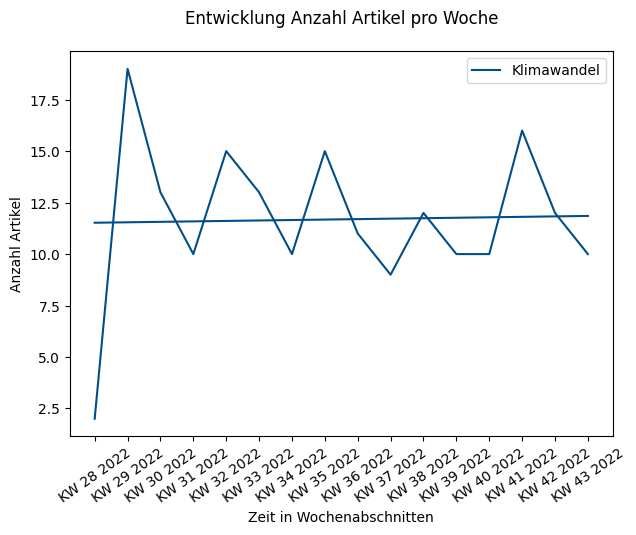

In [88]:
color = ["#004e89", "#ff6b35", "#f7c59f", "#1a659e"]

ax = df.plot(kind="line", x="timestamp", y=target, color=color, xlabel="Zeit in Wochenabschnitten", rot=35, figsize=(7,5), ylabel="Anzahl Artikel")

ax.set_xticks(df.timestamp.to_list())
ax.set_xticklabels(df.date)

plot_trendlines(df, on_axis=ax, ucolumn="timestamp", colors=color, columns=target)

ax.set_title(f'Entwicklung Anzahl Artikel pro Woche', pad=20)

ax.get_figure().savefig(f'figures/line-trend-stichwort/{("-".join(target))}.png', bbox_inches="tight", dpi=float(dpi))